# E - Connectivity

## Objective

This notebook investigates how goals connect to each other in our network. We analyze:

- **Co-occurrence patterns**: Which goals frequently appear together in users' bucket lists
- **Strong pairs**: The most strongly connected goal combinations
- **Network connectivity**: Overall structure and hub nodes
- **Category interactions**: How goals from different categories connect

**Note**: This analysis focuses on connectedness. Community detection is addressed separately.

In [1]:
import requests as rq
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict, Counter


# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

First, we read in our previously obtained dayzero_network.

In [2]:
url = "https://raw.githubusercontent.com/nicosrp/The-Architecture-of-Aspiration-A-Network-Perspective-on-Human-Goals/main/Networks/dayzero_network.pkl"
response = rq.get(url)
G = pickle.loads(response.content)

print(f"Network loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Network loaded: 2890 nodes, 219130 edges


In [3]:
# Basic network overview
print(f"Number of nodes (goals): {G.number_of_nodes():,}")
print(f"Number of edges (co-occurrences): {G.number_of_edges():,}")
print(f"Network is connected: {nx.is_connected(G)}")

# Check available node attributes
sample_node = list(G.nodes(data=True))[0]
print(f"\nAvailable node attributes: {list(sample_node[1].keys())}")

Number of nodes (goals): 2,890
Number of edges (co-occurrences): 219,130
Network is connected: False

Available node attributes: ['title', 'description', 'wants_to_do', 'have_done', 'comments', 'tags', 'included_by_our_users', 'category', 'country', 'city', 'other_map_location']


## 1. Network Overview

### Connected Components

The network is disconnected.

In [4]:
# Analyze connected components
components = list(nx.connected_components(G))
component_sizes = [len(c) for c in components]

print(f"Number of connected components: {len(components)}")
print(f"Largest component size: {max(component_sizes)} nodes ({max(component_sizes)/G.number_of_nodes()*100:.1f}%)")
print(f"Isolated nodes (singletons): {sum(1 for s in component_sizes if s == 1)}")

G_largest = G.subgraph(max(components, key=len)).copy()
print(f"\nLargest component: {G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges")

Number of connected components: 28
Largest component size: 2860 nodes (99.0%)
Isolated nodes (singletons): 25

Largest component: 2860 nodes, 219126 edges


## 2. Edge Weight Distribution

Edge weights represent how many users included both goals in their bucket lists. Below, we visualize the degree distribution and edge weight distribution (latter one in log-log scale), to get an initial glimpse of the distribution of connections in the network.

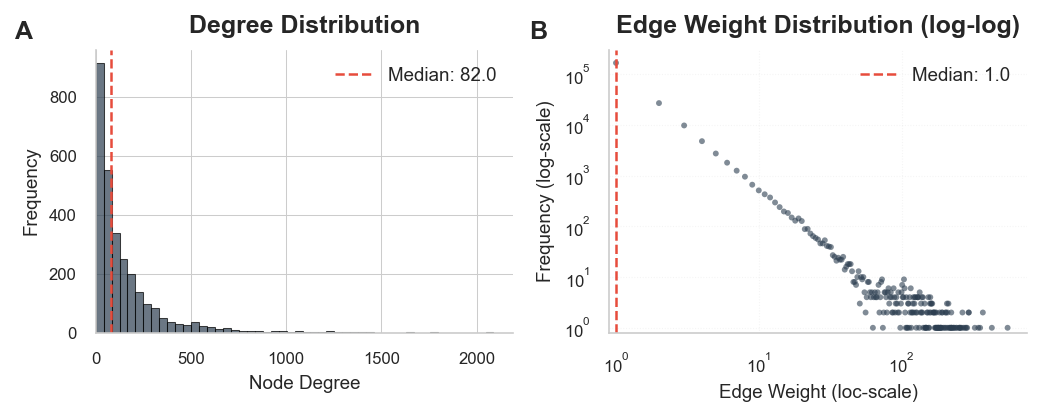


Degree statistics:
  Mean degree: 151.65
  Median degree: 82.00
  Max degree: 2089
  Min degree: 0


In [5]:
# Scientific publication-style visualization
# Clean, minimal design with scientific formatting

edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]
degrees = [G.degree(node) for node in G.nodes()]
weight_counts = Counter(edge_weights)
weights = sorted(weight_counts.keys())
frequencies = [weight_counts[w] for w in weights]


# Set publication style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Arial'],  # e.g. 'Arial', 'Helvetica', etc.
    'mathtext.fontset': 'stix',         # math text matches serif font family
    'font.size': 10,
    'axes.labelsize': 9,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 9,
    'figure.dpi': 150,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5
})

fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Add subplot labels
axes[0].text(-0.15, 1.1, 'A', transform=axes[0].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
axes[1].text(-0.15, 1.1, 'B', transform=axes[1].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')


# Left: Degree distribution
axes[0].hist(degrees, bins=50, color='#2C3E50', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Node Degree', fontsize=9, labelpad=4)
axes[0].set_ylabel('Frequency', fontsize=9, labelpad=4)
axes[0].set_title('Degree Distribution', fontsize=12, pad=8, fontweight='bold')
axes[0].axvline(np.median(degrees), color='#E74C3C', linestyle='--', linewidth=1.2, 
                label=f'Median: {np.median(degrees):.1f}')
axes[0].legend(frameon=False)
axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Right: Edge weight distribution (log-log)
axes[1].scatter(weights, frequencies, alpha=0.6, s=8, color='#2C3E50', edgecolors='none')
axes[1].set_xlabel('Edge Weight (loc-scale)', fontsize=9, labelpad=4)
axes[1].set_ylabel('Frequency (log-scale)', fontsize=9, labelpad=4)
axes[1].set_title('Edge Weight Distribution (log-log)', fontsize=12, pad=8, fontweight='bold')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].axvline(np.median(edge_weights), color='#E74C3C', linestyle='--', linewidth=1.2, 
                label=f'Median: {np.median(edge_weights):.1f}')
axes[1].legend(frameon=False)
axes[1].grid(True, alpha=0.2, linestyle=':', linewidth=0.5)
axes[1].set_xlim(left=min(weights) * 0.9)
axes[1].set_ylim(bottom=min(frequencies) * 0.8)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Reset style to default
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(f"\nDegree statistics:")
print(f"  Mean degree: {np.mean(degrees):.2f}")
print(f"  Median degree: {np.median(degrees):.2f}")
print(f"  Max degree: {np.max(degrees)}")
print(f"  Min degree: {np.min(degrees)}")

## 3. Strongest Co-occurring Goal Pairs (Absolute)

Next, we identify the most strongly connected goal pairs (highest edge weights).

In [6]:
# Get top 20 strongest connections
edges_with_weights = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]
top_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)[:20]

# Create DataFrame for display
strong_pairs = []
for u, v, weight in top_edges:
    goal1 = G.nodes[u]
    goal2 = G.nodes[v]
    strong_pairs.append({
        'Goal 1': goal1['title'],
        'Goal 2': goal2['title'],
        'Co-occurrences': weight,
        'Category 1': goal1['category'],
        'Category 2': goal2['category'],
        'Same Category': goal1['category'] == goal2['category']
    })

df_strong_pairs = pd.DataFrame(strong_pairs)
print("Top 20 Strongest Goal Pairs:\n")
print(df_strong_pairs.to_string(index=False))

Top 20 Strongest Goal Pairs:

                                                       Goal 1                           Goal 2  Co-occurrences                Category 1                             Category 2  Same Category
                                                 Donate blood                     Get a tattoo             553                    Health                            Experiences          False
Leave an inspirational note inside a book for someone to find                     Donate blood             429 Acts of kindness/altruism                                 Health          False
                                                 Donate blood           Find out my blood type             371                    Health                                 Health           True
                                                 Donate blood          See the Northern Lights             371                    Health                                 Nature          False
Leave an inspir

### Cross-Category Patterns

Here we analyze how goals from different categories connect, including within and cross category connections, as well as cross category connections.

In [7]:
# Analyze category co-occurrence patterns
category_pairs = []
for u, v, data in G.edges(data=True):
    cat1 = G.nodes[u].get('category', 'Unknown')
    cat2 = G.nodes[v].get('category', 'Unknown')
    # Normalize order for counting
    cat_pair = tuple(sorted([cat1, cat2]))
    category_pairs.append({
        'pair': cat_pair,
        'weight': data['weight'],
        'same_category': cat1 == cat2
    })

df_cat_pairs = pd.DataFrame(category_pairs)

# Count connections within and between categories
same_cat = df_cat_pairs[df_cat_pairs['same_category']]
diff_cat = df_cat_pairs[~df_cat_pairs['same_category']]

# Totals by edge count and by weight
total_edges = len(df_cat_pairs)
total_weight = df_cat_pairs['weight'].sum()
same_edges = len(same_cat)
diff_edges = len(diff_cat)
same_weight = same_cat['weight'].sum()
diff_weight = diff_cat['weight'].sum()

print(f"Within-category connections: {same_edges:,} ({same_edges/total_edges*100:.1f}%)")
print(f"Cross-category connections: {diff_edges:,} ({diff_edges/total_edges*100:.1f}%)")
print(f"Within-category total weight: {same_weight:,} ({same_weight/total_weight*100:.1f}%)")
print(f"Cross-category total weight: {diff_weight:,} ({diff_weight/total_weight*100:.1f}%)")

print(f"\nAverage weight within-category: {same_cat['weight'].mean():.2f}")
print(f"Average weight cross-category: {diff_cat['weight'].mean():.2f}")

# Top cross-category pairs
cross_cat_summary = diff_cat.groupby('pair').agg({
    'weight': ['sum', 'count', 'mean']
}).reset_index()
cross_cat_summary.columns = ['Category Pair', 'Total Weight', 'Count', 'Avg Weight']
cross_cat_summary = cross_cat_summary.sort_values('Total Weight', ascending=False).head(15)

print("\nTop 15 Cross-Category Connections (by total weight):")
for idx, row in cross_cat_summary.iterrows():
    print(f"{row['Category Pair'][0]} <-> {row['Category Pair'][1]}: {row['Total Weight']:.0f} total ({row['Count']:.0f} edges)")

Within-category connections: 61,219 (27.9%)
Cross-category connections: 157,911 (72.1%)
Within-category total weight: 100,517 (23.0%)
Cross-category total weight: 336,556 (77.0%)

Average weight within-category: 1.64
Average weight cross-category: 2.13

Top 15 Cross-Category Connections (by total weight):
Places of interest <-> Travel destinations: 56802 total (37433 edges)
Nature <-> Travel destinations: 21153 total (12609 edges)
Nature <-> Places of interest: 19929 total (13447 edges)
Health <-> Travel destinations: 14050 total (3779 edges)
Experiences <-> Travel destinations: 13233 total (5323 edges)
Events & concerts <-> Travel destinations: 11697 total (8452 edges)
New skills <-> Travel destinations: 11305 total (5615 edges)
Events & concerts <-> Places of interest: 10584 total (8162 edges)
Food <-> Travel destinations: 10174 total (5132 edges)
Experiences <-> Places of interest: 8406 total (4334 edges)
Health <-> Places of interest: 7930 total (2981 edges)
New skills <-> Places o

We additionally establish, that all categories have connections to all other categories, without exception.

In [8]:
# Check for category combinations with no connection at all (including self-pairs)
from itertools import combinations_with_replacement

# Collect categories from graph nodes (exclude 'Unknown')
categories = sorted({G.nodes[n].get('category', 'Unknown') for n in G.nodes()})
categories = [c for c in categories if c != 'Unknown']

# Ensure df_cat_pairs (from previous cell) exists; otherwise, build it quickly
try:
    df_cat_pairs
except NameError:
    category_pairs = []
    for u, v, data in G.edges(data=True):
        cat1 = G.nodes[u].get('category', 'Unknown')
        cat2 = G.nodes[v].get('category', 'Unknown')
        if 'Unknown' in (cat1, cat2):
            continue
        pair = tuple(sorted([cat1, cat2]))
        category_pairs.append({'pair': pair, 'weight': data['weight'], 'same_category': cat1 == cat2})
    df_cat_pairs = pd.DataFrame(category_pairs)

# Aggregate weights by unordered category pair
if len(df_cat_pairs) == 0:
    print("No category edges available.")
else:
    pair_weight = df_cat_pairs.groupby('pair')['weight'].sum().to_dict()

    # All possible unordered pairs (including self pairs)
    all_pairs = list(combinations_with_replacement(categories, 2))

    # Pairs with zero total weight (not present in data)
    zero_pairs = [p for p in all_pairs if pair_weight.get(p, 0) == 0]
    zero_cross = [p for p in zero_pairs if p[0] != p[1]]
    zero_self = [p for p in zero_pairs if p[0] == p[1]]

    print(f"Categories considered: {len(categories)}")
    print(f"Total possible pairs (incl. self): {len(all_pairs):,}")
    print(f"Pairs with zero connection (all): {len(zero_pairs):,}")
    print(f"  - Cross-category zero pairs: {len(zero_cross):,}")
    print(f"  - Self zero pairs: {len(zero_self):,}")

    if zero_cross:
        print("\nZero-connection cross-category pairs:")
        for a, b in zero_cross[:50]:
            print(f"  {a} ↔ {b}")
        if len(zero_cross) > 50:
            print(f"  ... and {len(zero_cross) - 50} more")

    if zero_self:
        print("\nCategories with no self-connections:")
        for a, _ in zero_self:
            print(f"  {a}")

Categories considered: 15
Total possible pairs (incl. self): 120
Pairs with zero connection (all): 0
  - Cross-category zero pairs: 0
  - Self zero pairs: 0


The following matrix shows how different categories connect. The resulting heatmap suggests that we need measures to account for the influence of the category size.

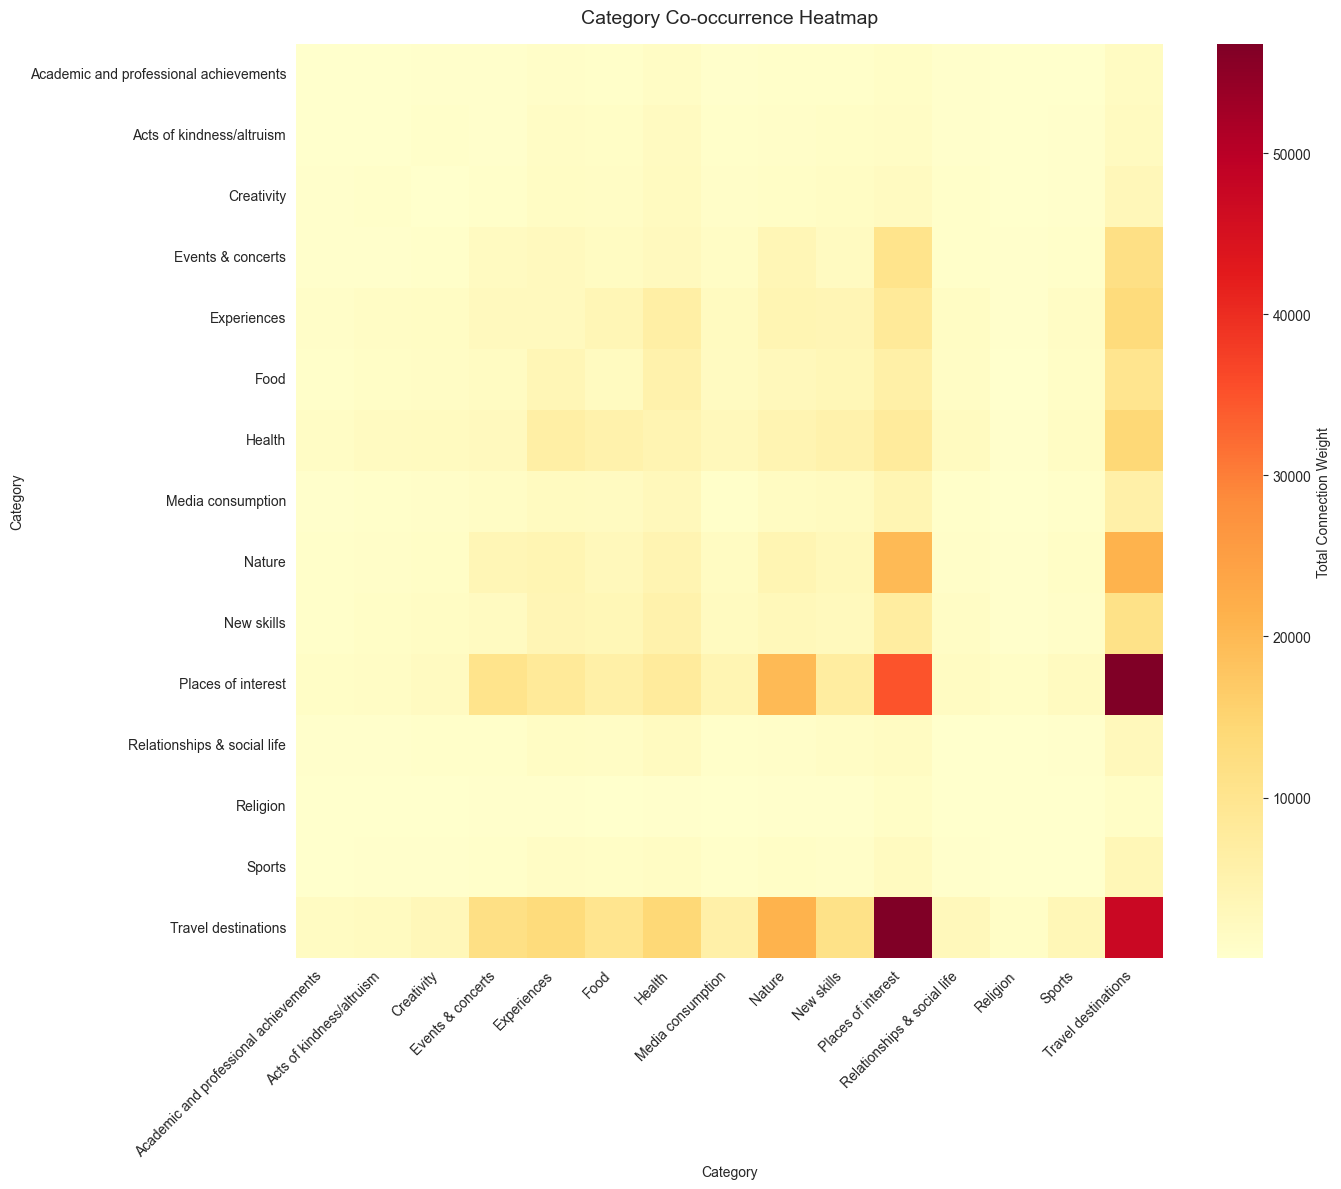

In [9]:
# Create category interaction matrix
# Build matrix of connections between categories
cat_matrix = defaultdict(lambda: defaultdict(int))
for u, v, data in G.edges(data=True):
    cat1 = G.nodes[u].get('category', 'Unknown')
    cat2 = G.nodes[v].get('category', 'Unknown')
    weight = data['weight']
    cat_matrix[cat1][cat2] += weight
    if cat1 != cat2:  # Add symmetric entry for cross-category
        cat_matrix[cat2][cat1] += weight

# Convert to DataFrame
all_cats = sorted(set(cat1 for cat1 in cat_matrix.keys() if cat1 != 'Unknown'))
matrix_data = []
for cat1 in all_cats:
    row = []
    for cat2 in all_cats:
        row.append(cat_matrix[cat1][cat2])
    matrix_data.append(row)

df_matrix = pd.DataFrame(matrix_data, index=all_cats, columns=all_cats)

# Visualize heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(df_matrix, cmap='YlOrRd', annot=False, fmt='d', 
            cbar_kws={'label': 'Total Connection Weight'})
plt.title('Category Co-occurrence Heatmap', fontsize=14, pad=15)
plt.xlabel('Category')
plt.ylabel('Category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Normalized Category Co-occurrence

Raw totals are dominated by category size. Two useful normalizations:

- Row proportion: share of a category's connections going to each other category (rows sum to 1).
- PMI (log-lift): log2(actual / expected under independence). > 0 = stronger-than-expected; < 0 = weaker.

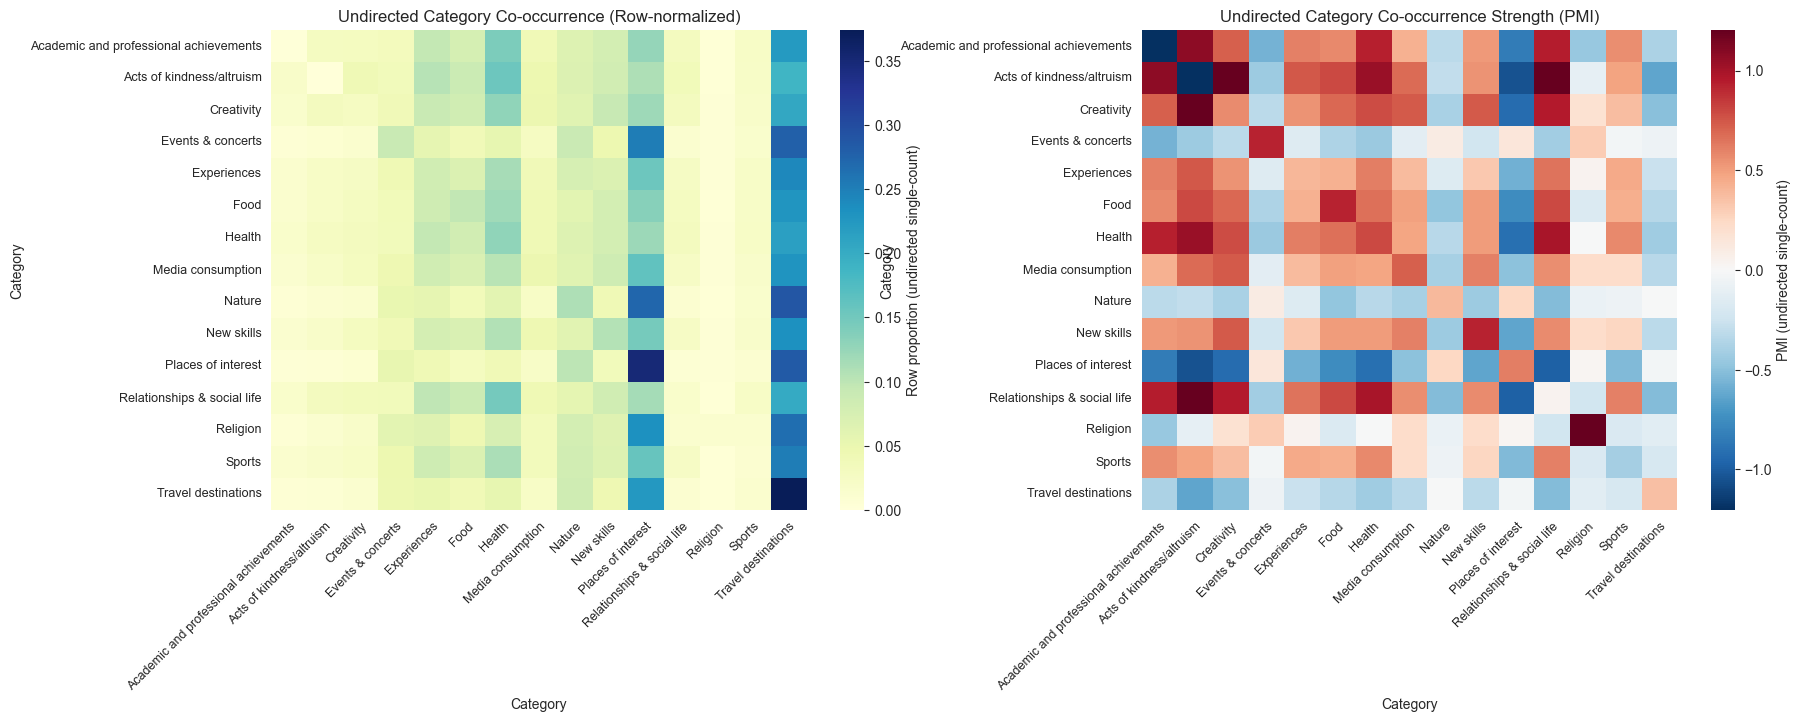

Undirected total mass (self + each cross once): 436,996

Top 10 strongest cross-category pairs (undirected single-count):
  Acts of kindness/altruism ↔ Relationships & social life: weight=218, expected=94.4, PMI=1.21
  Acts of kindness/altruism ↔ Creativity: weight=240, expected=104.8, PMI=1.20
  Academic and professional achievements ↔ Acts of kindness/altruism: weight=112, expected=53.1, PMI=1.08
  Acts of kindness/altruism ↔ Health: weight=901, expected=438.5, PMI=1.04
  Health ↔ Relationships & social life: weight=1,042, expected=525.0, PMI=0.99
  Creativity ↔ Relationships & social life: weight=243, expected=125.5, PMI=0.95
  Academic and professional achievements ↔ Relationships & social life: weight=122, expected=63.5, PMI=0.94
  Academic and professional achievements ↔ Health: weight=564, expected=295.1, PMI=0.94
  Food ↔ Relationships & social life: weight=621, expected=357.8, PMI=0.80
  Acts of kindness/altruism ↔ Food: weight=517, expected=298.9, PMI=0.79

Top 10 weakest cro

In [10]:
# Undirected category normalization (simplified & corrected)
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Aggregate undirected weights (each cross-category pair counted once)
undirected_w = defaultdict(float)
for u, v, data in G.edges(data=True):
    c1 = G.nodes[u].get('category', 'Unknown') or 'Unknown'
    c2 = G.nodes[v].get('category', 'Unknown') or 'Unknown'
    if 'Unknown' in (c1, c2):
        continue
    a, b = sorted([c1, c2])
    undirected_w[(a, b)] += data['weight']

cats = sorted({c for (a,b) in undirected_w.keys() for c in (a,b)})
idx = {c:i for i,c in enumerate(cats)}

# 2. Build undirected matrix U (no duplication). For visualization we keep it symmetric but semantics: U_ij is undirected weight.
U = np.zeros((len(cats), len(cats)), dtype=float)
for (a,b), w in undirected_w.items():
    i,j = idx[a], idx[b]
    U[i,j] = w
    U[j,i] = w  # symmetric view

# 3. Category masses & total mass (each cross once)
cat_masses = U.sum(axis=1)  # because each row already has each cross once and self once
# (Since matrix is symmetric with duplication, row sum counts each cross twice; adjust by dividing cross portion) -> Correct it:
true_cat_masses = []
for i in range(len(cats)):
    self_w = U[i,i]
    row_sum = U[i,:].sum()
    cross_twice = row_sum - self_w
    cross_once = cross_twice / 2.0
    true_cat_masses.append(self_w + cross_once)
true_cat_masses = np.array(true_cat_masses)

total_mass = true_cat_masses.sum()

# 4. Expected under independence (pure undirected)
expected = np.outer(true_cat_masses, true_cat_masses) / max(total_mass, 1e-9)

# 5. Row proportions (using undirected counts): for proportion we want single-count perspective
# Reconstruct single-count matrix S (upper triangle + diagonal); easiest is divide off-diagonals by 2 in U to remove duplication
S = U.copy()
for i in range(len(cats)):
    for j in range(len(cats)):
        if i != j:
            S[i,j] = U[i,j] / 2.0
row_sums_single = S.sum(axis=1)
row_prop = np.divide(S, row_sums_single.reshape(-1,1), out=np.zeros_like(S), where=row_sums_single.reshape(-1,1)!=0)

# 6. PMI: use single-count S vs expected (which is single-count); PMI_ij = log2( S_ij / expected_ij )
PMI = np.zeros_like(S)
for i in range(len(cats)):
    for j in range(len(cats)):
        obs = S[i,j]
        exp = expected[i,j]
        if obs <= 0 or exp <= 0:
            PMI[i,j] = np.log2(1e-9)
        else:
            PMI[i,j] = np.log2(obs/exp)

# 7. DataFrames for visualization (show single-count heatmaps; diagonal kept)
df_row_prop_undir = pd.DataFrame(row_prop, index=cats, columns=cats)
df_pmi_undir = pd.DataFrame(PMI, index=cats, columns=cats)

# 8. Plot heatmaps (mask optional later)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.subplots_adjust(bottom=0.30, left=0.20, right=0.97, top=0.90, wspace=0.30)

sns.heatmap(df_row_prop_undir, cmap='YlGnBu', vmin=0, vmax=np.nanmax(df_row_prop_undir.values),
            cbar_kws={'label': 'Row proportion (undirected single-count)'}, ax=axes[0])
axes[0].set_title('Undirected Category Co-occurrence (Row-normalized)')
axes[0].set_xlabel('Category'); axes[0].set_ylabel('Category')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=9)
plt.setp(axes[0].get_yticklabels(), rotation=0, fontsize=9)

vmax = np.nanpercentile(np.abs(df_pmi_undir.values), 98)
sns.heatmap(df_pmi_undir, cmap='RdBu_r', center=0, vmin=-vmax, vmax=vmax,
            cbar_kws={'label': 'PMI (undirected single-count)'}, ax=axes[1])
axes[1].set_title('Undirected Category Co-occurrence Strength (PMI)')
axes[1].set_xlabel('Category'); axes[1].set_ylabel('Category')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=9)
plt.setp(axes[1].get_yticklabels(), rotation=0, fontsize=9)
plt.show()

print(f"Undirected total mass (self + each cross once): {int(total_mass):,}")

# 9. Top / bottom cross pairs by PMI (single-count; upper triangle only, exclude diagonal)
cross_pairs = []
for i,a in enumerate(cats):
    for j,b in enumerate(cats):
        if j <= i:  # skip diagonal & lower
            continue
        obs = S[i,j]
        exp = expected[i,j]
        pmi_val = PMI[i,j]
        cross_pairs.append((a,b,obs,exp,pmi_val))

cross_pairs_sorted = sorted(cross_pairs, key=lambda x: x[4], reverse=True)
cross_pairs_low = sorted(cross_pairs, key=lambda x: x[4])

print("\nTop 10 strongest cross-category pairs (undirected single-count):")
for a,b,obs,exp,pmi_val in cross_pairs_sorted[:10]:
    print(f"  {a} ↔ {b}: weight={int(obs):,}, expected={exp:.1f}, PMI={pmi_val:.2f}")

print("\nTop 10 weakest cross-category pairs (undirected single-count):")
for a,b,obs,exp,pmi_val in cross_pairs_low[:10]:
    print(f"  {a} ↔ {b}: weight={int(obs):,}, expected={exp:.1f}, PMI={pmi_val:.2f}")

# 10. Self cohesion list
self_list = []
for i,c in enumerate(cats):
    obs = S[i,i]
    exp = expected[i,i]
    pmi_val = PMI[i,i]
    self_list.append((c, obs, exp, pmi_val))
print("\nWithin-category PMI (undirected single-count):")
for c, obs, exp, pmi_val in sorted(self_list, key=lambda x:x[3], reverse=True):
    print(f"  {c}: weight={int(obs):,}, expected={exp:.1f}, PMI={pmi_val:.2f}")

While row proportion accounts for the size of a rows own category, the PMI visualization gives us a better overview of how certain connections are 'special', as it accounts for the expected values in relation to the observed values of a connection between two categories.

Below, we additionally visualized the PMI heatmap on its own.

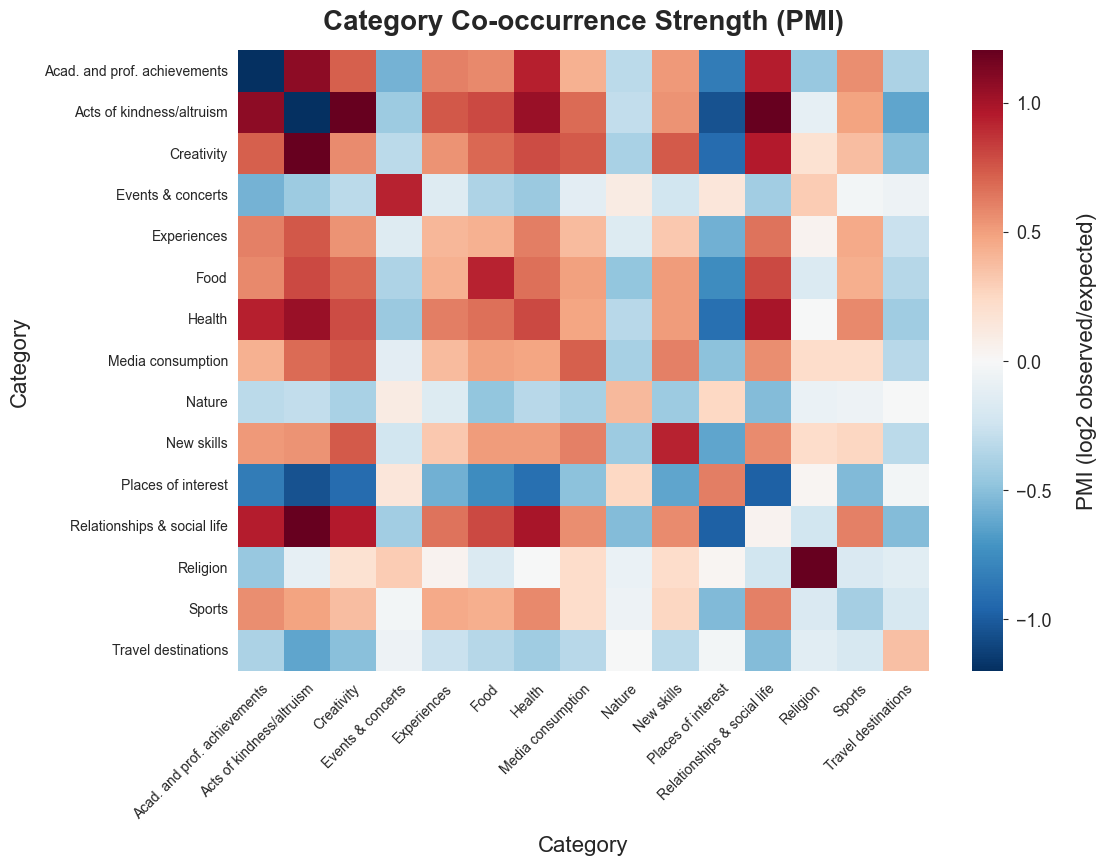

In [11]:
# PMI Heatmap (standalone with compact labels)

# Function to abbreviate long category names
def compact_label(label):
    """Abbreviate long category names for better visualization"""
    # Specific abbreviations for long category names
    if label == 'Academic and professional achievements':
        return 'Acad. and prof. achievements'
    else:
        return label

# Create compact labels
cats_compact = [compact_label(c) for c in cats]
df_pmi_compact = pd.DataFrame(PMI, index=cats_compact, columns=cats_compact)

# Plot single PMI heatmap
fig, ax = plt.subplots(figsize=(12, 9))
fig.subplots_adjust(bottom=0.25, left=0.23, right=0.95, top=0.94)

vmax = np.nanpercentile(np.abs(df_pmi_undir.values), 98)
hm = sns.heatmap(df_pmi_compact, cmap='RdBu_r', center=0, vmin=-vmax, vmax=vmax,
            cbar_kws={'label': 'PMI (log2 observed/expected)'}, ax=ax, square=False)
ax.set_title('Category Co-occurrence Strength (PMI)', fontsize=20, pad=15, fontweight='bold')
ax.set_xlabel('Category', fontsize=16, labelpad=10)
ax.set_ylabel('Category', fontsize=16, labelpad=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=10)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10, va='center')
# Make colorbar label larger and add extra spacing from colorbar
cbar = hm.collections[0].colorbar
cbar.set_label('PMI (log2 observed/expected)', fontsize=16, labelpad=18)
# Increase tick label size and pad between ticks and tick labels for clarity
cbar.ax.tick_params(labelsize=13, pad=6)
plt.show()

## 4. Node Statistics

Here, we calculate node-level statistics for later analysis.

In [12]:
# Calculate degree and weighted degree for each node
node_stats = []
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    degree = len(neighbors)
    weighted_degree = sum(G[node][neighbor]['weight'] for neighbor in neighbors)
    
    node_data = G.nodes[node]
    node_stats.append({
        'node': node,
        'title': node_data.get('title', 'Unknown'),
        'category': node_data.get('category', 'Unknown'),
        'degree': degree,
        'weighted_degree': weighted_degree,
        'included_by_users': node_data.get('included_by_our_users', 0)
    })

df_nodes = pd.DataFrame(node_stats)

print(f"Created node statistics DataFrame with {len(df_nodes)} nodes")
print(f"  Mean degree: {df_nodes['degree'].mean():.1f}")
print(f"  Median degree: {df_nodes['degree'].median():.1f}")

Created node statistics DataFrame with 2890 nodes
  Mean degree: 151.6
  Median degree: 82.0


### Within-Category vs Cross-Category Connectivity (Normalized)

Do goals connect more to their own category or to other categories? Here, we look at a different visualization, comparing within and cross-category percentages of each category.

Within-Category vs Cross-Category Connectivity (All Categories):\n
                              Category  Within %  Within Weight %  Total Connections  Num Goals
                   Travel destinations 25.770382        22.996979             117604       1009
                    Places of interest 23.174963        21.170958             105765        866
                                Nature  6.634223         5.814660              38015        291
                            New skills  5.286021         5.575321              17726        108
                     Events & concerts  5.269120         4.780339              27367        256
                                  Food  4.084052         5.082865              15181         96
                     Media consumption  3.013598         2.490269              10884         80
                           Experiences  2.333627         4.295997              15898         83
                                Sports  1.012184         0.578991    

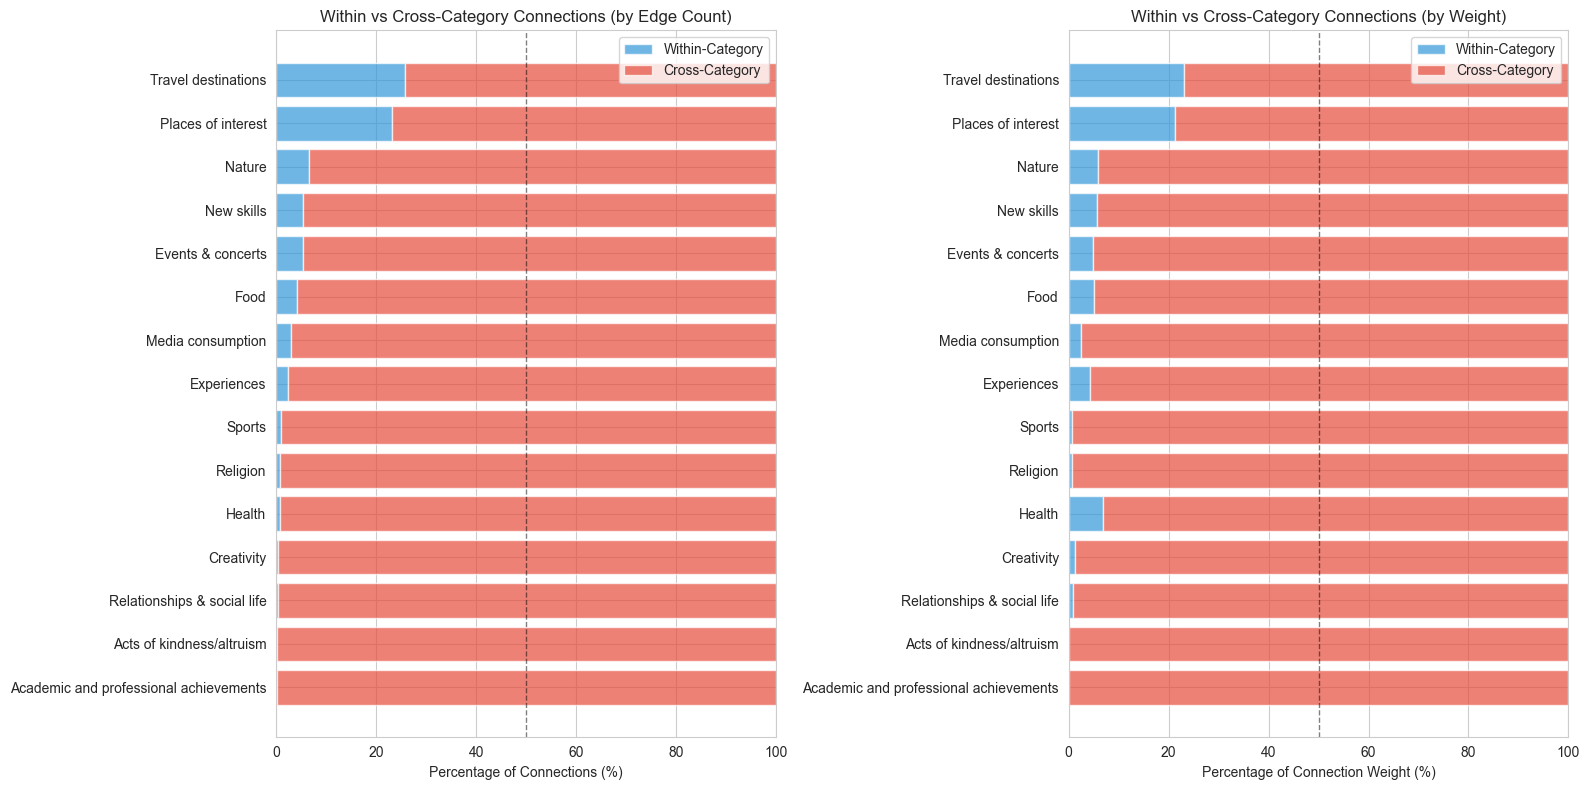


Key Insights:
  • Most insular category: Travel destinations (25.8% within-category)
  • Most cross-connected: Academic and professional achievements (0.1% within-category)
  • Average within-category: 5.3%


In [13]:
# For each category, calculate what percentage of connections are within vs cross-category
category_connectivity = []

for cat in all_cats:
    # Get all nodes in this category
    cat_nodes = df_nodes[df_nodes['category'] == cat]['node'].tolist()
    
    # Count connections
    within_cat_edges = 0
    within_cat_weight = 0
    cross_cat_edges = 0
    cross_cat_weight = 0
    
    for node in cat_nodes:
        for neighbor in G.neighbors(node):
            neighbor_cat = G.nodes[neighbor].get('category', 'Unknown')
            weight = G[node][neighbor]['weight']
            
            if neighbor_cat == cat:
                within_cat_edges += 1
                within_cat_weight += weight
            else:
                cross_cat_edges += 1
                cross_cat_weight += weight
    
    # Divide by 2 since edges are counted twice (both directions)
    within_cat_edges = within_cat_edges / 2
    within_cat_weight = within_cat_weight / 2
    
    total_edges = within_cat_edges + cross_cat_edges
    total_weight = within_cat_weight + cross_cat_weight
    
    if total_edges > 0:
        within_pct = (within_cat_edges / total_edges) * 100
        within_weight_pct = (within_cat_weight / total_weight) * 100
        
        category_connectivity.append({
            'Category': cat,
            'Within-Category Edges': int(within_cat_edges),
            'Cross-Category Edges': int(cross_cat_edges),
            'Within %': within_pct,
            'Within-Category Weight': int(within_cat_weight),
            'Cross-Category Weight': int(cross_cat_weight),
            'Within Weight %': within_weight_pct,
            'Total Connections': int(total_edges),
            'Num Goals': len(cat_nodes)
        })

df_cat_connectivity = pd.DataFrame(category_connectivity)
df_cat_connectivity = df_cat_connectivity.sort_values('Within %', ascending=False)

print("Within-Category vs Cross-Category Connectivity (All Categories):\\n")
print(df_cat_connectivity[['Category', 'Within %', 'Within Weight %', 'Total Connections', 'Num Goals']].to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Percentage of within-category connections
y_pos = range(len(df_cat_connectivity))
cross_pct = 100 - df_cat_connectivity['Within %']
axes[0].barh(y_pos, df_cat_connectivity['Within %'], color='#3498db', alpha=0.7, label='Within-Category')
axes[0].barh(y_pos, cross_pct, left=df_cat_connectivity['Within %'], 
             color='#e74c3c', alpha=0.7, label='Cross-Category')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(df_cat_connectivity['Category'])
axes[0].set_xlabel('Percentage of Connections (%)')
axes[0].set_title('Within vs Cross-Category Connections (by Edge Count)')
axes[0].axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlim(0, 100)
axes[0].legend()
axes[0].invert_yaxis()

# By weight
cross_weight_pct = 100 - df_cat_connectivity['Within Weight %']
axes[1].barh(y_pos, df_cat_connectivity['Within Weight %'], color='#3498db', alpha=0.7, label='Within-Category')
axes[1].barh(y_pos, cross_weight_pct, left=df_cat_connectivity['Within Weight %'], 
             color='#e74c3c', alpha=0.7, label='Cross-Category')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(df_cat_connectivity['Category'])
axes[1].set_xlabel('Percentage of Connection Weight (%)')
axes[1].set_title('Within vs Cross-Category Connections (by Weight)')
axes[1].axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlim(0, 100)
axes[1].legend()
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nKey Insights:")
print(f"  • Most insular category: {df_cat_connectivity.iloc[0]['Category']} ({df_cat_connectivity.iloc[0]['Within %']:.1f}% within-category)")
print(f"  • Most cross-connected: {df_cat_connectivity.iloc[-1]['Category']} ({df_cat_connectivity.iloc[-1]['Within %']:.1f}% within-category)")
print(f"  • Average within-category: {df_cat_connectivity['Within %'].mean():.1f}%")

## 5. Node Connectivity Patterns

### Most Connected Goals by Category

Here we look at which goals serve as hubs within each category? For this, we look at high degree nodes.

In [14]:
# Top connected goal per major category
major_categories = ['Travel destinations', 'Places of interest', 'Nature', 'Health', 
                    'Experiences', 'New skills', 'Food', 'Events & concerts']

print("Hub Goal for Each Major Category:\n")
for cat in major_categories:
    cat_goals = df_nodes[df_nodes['category'] == cat].nlargest(3, 'degree')
    if len(cat_goals) > 0:
        print(f"{cat}:")
        for _, goal in cat_goals.iterrows():
            print(f"  • {goal['title']} (degree: {goal['degree']}, users: {goal['included_by_users']})")
        print()

Hub Goal for Each Major Category:

Travel destinations:
  • Visit the Grand Canyon (degree: 1756, users: 569)
  • Visit Italy (degree: 1372, users: 409)
  • Go to Las Vegas (degree: 1242, users: 498)

Places of interest:
  • See the Eiffel Tower (degree: 1215, users: 97)
  • Visit the Statue of Liberty (degree: 1186, users: 113)
  • Visit the Great Wall of China (degree: 1125, users: 94)

Nature:
  • See the Northern Lights (degree: 2089, users: 926)
  • Watch a meteor shower (degree: 1319, users: 463)
  • Visit Yosemite National Park (degree: 864, users: 65)

Health:
  • Donate blood (degree: 1662, users: 1672)
  • Get a massage (degree: 1429, users: 811)
  • Find out my blood type (degree: 1350, users: 868)

Experiences:
  • Get a tattoo (degree: 1767, users: 1458)
  • Go skydiving (degree: 1248, users: 685)
  • Fly a kite (degree: 996, users: 463)

New skills:
  • Learn Spanish (degree: 1266, users: 441)
  • Learn to knit (degree: 1037, users: 430)
  • Learn to identify 10 constella

We additionally look at the 15 most connected goals (degree) overall, sorted in ascending order.

In [ ]:
# Most connected goals
top_hubs = df_nodes.nlargest(15, 'degree')[['title', 'category', 'degree', 'weighted_degree', 'included_by_users']]

print("\nTop 15 Most Connected Goals (Hubs):")
print(top_hubs.to_string(index=False))


Top 15 Most Connected Goals (Hubs):
                                                        title                  category  degree  weighted_degree  included_by_users
                                      See the Northern Lights                    Nature    2089            14593                926
                                                 Get a tattoo               Experiences    1767            13804               1458
                                       Visit the Grand Canyon       Travel destinations    1756            12226                569
                                                 Donate blood                    Health    1662            14836               1672
                                                Get a massage                    Health    1429             9469                811
Leave an inspirational note inside a book for someone to find Acts of kindness/altruism    1419            11512               1183
                                       

## 6. Category-Based Connectivity

How do different goal categories connect in the network? For this, we look at average degrees of goals per category.

Connectivity Statistics by Category:

                                        Avg Degree  Median Degree  Max Degree  Avg Weighted Degree  Median Weighted Degree  Count
category                                                                                                                         
Academic and professional achievements       718.5          718.5        1214               3951.0                  3951.0      2
Health                                       658.6          504.0        1662               3841.3                  1469.0     17
Creativity                                   601.0          625.5        1073               2601.2                  2185.5      6
Acts of kindness/altruism                    405.8           83.0        1419               2934.8                    94.0      4
Relationships & social life                  385.8          387.5        1102               1757.0                   906.0      8
Experiences                                  196.0  

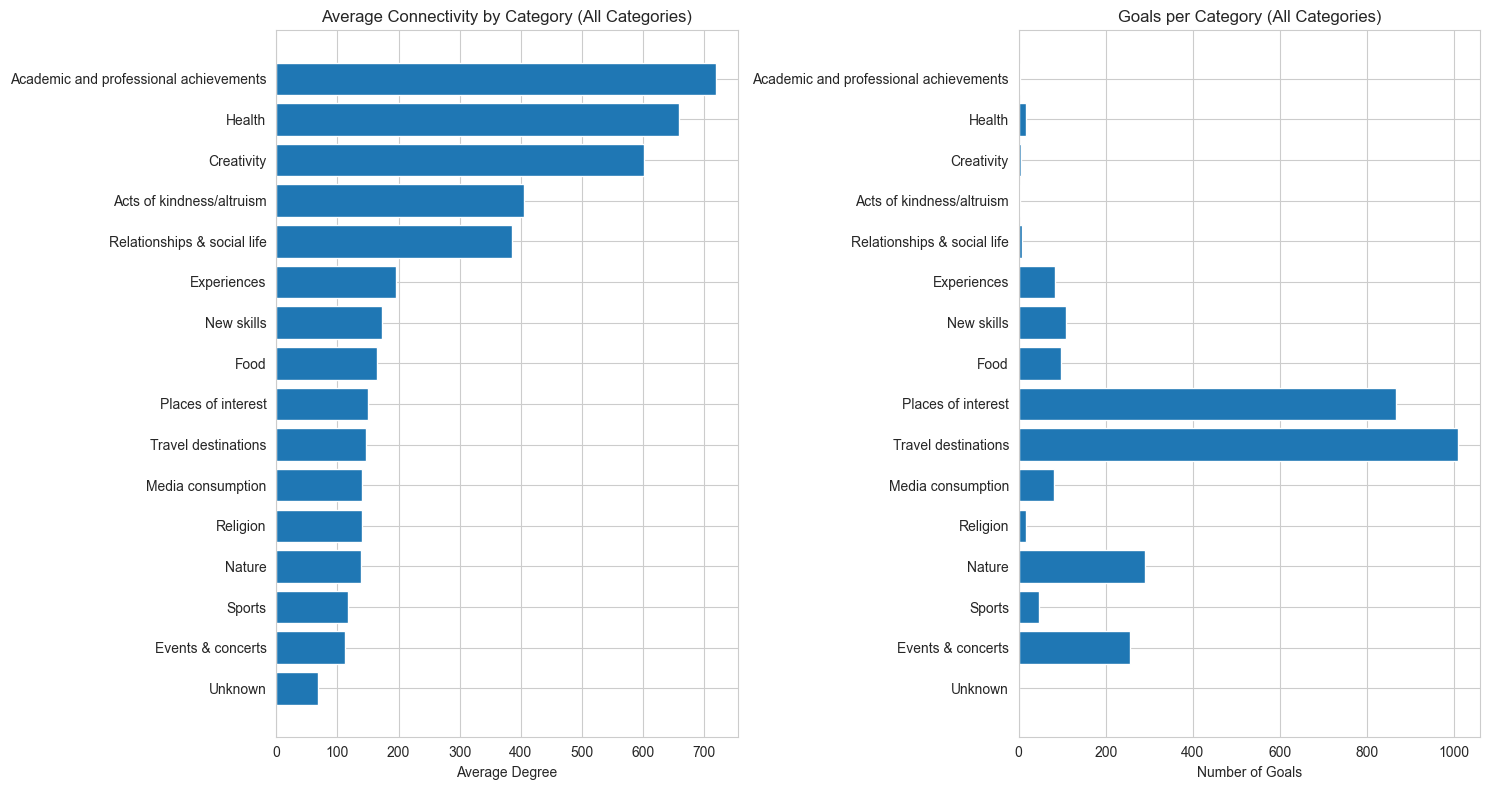

In [16]:
# Analyze connectivity by category
category_stats = df_nodes.groupby('category').agg({
    'degree': ['mean', 'median', 'max'],
    'weighted_degree': ['mean', 'median'],
    'node': 'count'
}).round(1)
category_stats.columns = ['Avg Degree', 'Median Degree', 'Max Degree', 'Avg Weighted Degree', 'Median Weighted Degree', 'Count']
category_stats = category_stats.sort_values('Avg Degree', ascending=False)

print("Connectivity Statistics by Category:\n")
print(category_stats.to_string())

# Visualize - show all categories
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Average degree by category
axes[0].barh(range(len(category_stats)), category_stats['Avg Degree'])
axes[0].set_yticks(range(len(category_stats)))
axes[0].set_yticklabels(category_stats.index)
axes[0].set_xlabel('Average Degree')
axes[0].set_title('Average Connectivity by Category (All Categories)')
axes[0].invert_yaxis()

# Number of goals per category
axes[1].barh(range(len(category_stats)), category_stats['Count'])
axes[1].set_yticks(range(len(category_stats)))
axes[1].set_yticklabels(category_stats.index)
axes[1].set_xlabel('Number of Goals')
axes[1].set_title('Goals per Category (All Categories)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Network Assortativity

Next, we look at degree and attribute based assortativity.

In [17]:
degree_assortativity = nx.degree_assortativity_coefficient(G, weight='weight')

print("="*60)
print("NETWORK ASSORTATIVITY ANALYSIS")
print("="*60)

print(f"\nDegree Assortativity Coefficient: {degree_assortativity:.4f}")
if degree_assortativity > 0.1:
    interpretation = "Assortative: High-degree goals tend to connect with other high-degree goals"
elif degree_assortativity < -0.1:
    interpretation = "Disassortative: High-degree goals tend to connect with low-degree goals"
else:
    interpretation = "Neutral: No strong degree correlation pattern"
print(f"Interpretation: {interpretation}")

# For comparison, calculate on largest component
degree_assortativity_largest = nx.degree_assortativity_coefficient(G_largest, weight='weight')
print(f"\nDegree Assortativity (Largest Component): {degree_assortativity_largest:.4f}")

NETWORK ASSORTATIVITY ANALYSIS

Degree Assortativity Coefficient: -0.1249
Interpretation: Disassortative: High-degree goals tend to connect with low-degree goals

Degree Assortativity (Largest Component): -0.1249


In [18]:
# Calculate attribute assortativity for category
# Measures if goals in the same category connect more than expected

try:
    category_assortativity = nx.attribute_assortativity_coefficient(G, 'category')
    print(f"\nCategory Assortativity Coefficient: {category_assortativity:.4f}")
    
    if category_assortativity > 0.1:
        cat_interpretation = "Strong within-category preference: Goals connect more to others in same category"
    elif category_assortativity < -0.1:
        cat_interpretation = "Cross-category preference: Goals connect more to different categories"
    else:
        cat_interpretation = "Neutral: No strong category-based connection pattern"
    print(f"Interpretation: {cat_interpretation}")
    
    # For largest component
    category_assortativity_largest = nx.attribute_assortativity_coefficient(G_largest, 'category')
    print(f"Category Assortativity (Largest Component): {category_assortativity_largest:.4f}")
    
except Exception as e:
    print(f"\nCould not calculate category assortativity: {e}")

print("\n" + "="*60)


Category Assortativity Coefficient: 0.0746
Interpretation: Neutral: No strong category-based connection pattern
Category Assortativity (Largest Component): 0.0746



Finally, we confirm that overall the average neighbor degree slightly decreases the larger the node degree.

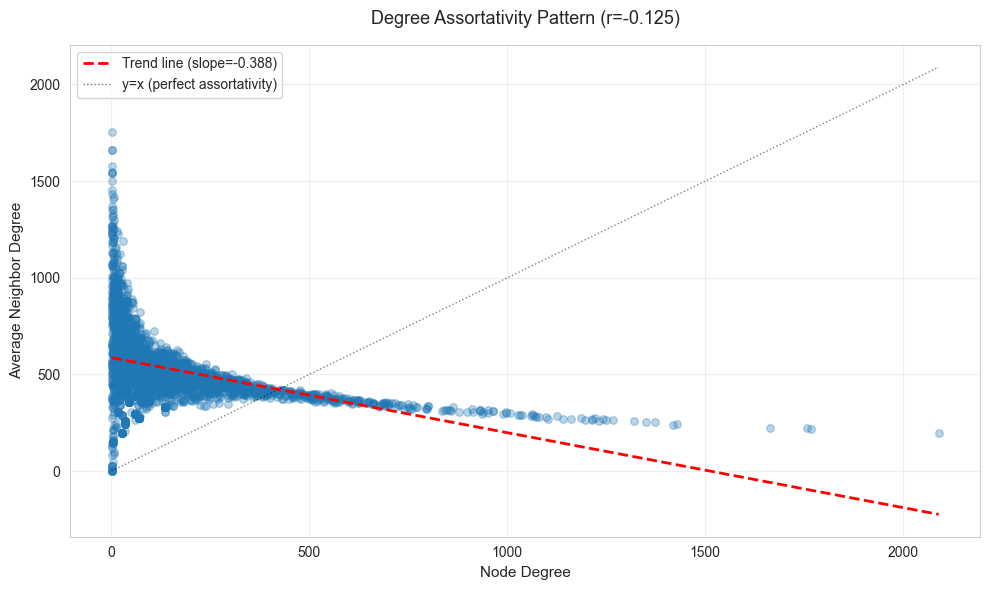

Correlation coefficient: -0.4083


In [19]:
# Visualize degree assortativity pattern
# Create scatter plot of average neighbor degree vs node degree

avg_neighbor_degrees = []
node_degrees = []

for node in G.nodes():
    degree = G.degree(node)
    neighbors = list(G.neighbors(node))
    if neighbors:
        avg_neighbor_degree = np.mean([G.degree(n) for n in neighbors])
        node_degrees.append(degree)
        avg_neighbor_degrees.append(avg_neighbor_degree)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with transparency
ax.scatter(node_degrees, avg_neighbor_degrees, alpha=0.3, s=30)

# Add trend line
z = np.polyfit(node_degrees, avg_neighbor_degrees, 1)
p = np.poly1d(z)
x_line = np.linspace(min(node_degrees), max(node_degrees), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend line (slope={z[0]:.3f})')

# Add reference line (y=x) for perfect assortativity
ax.plot([min(node_degrees), max(node_degrees)], 
        [min(node_degrees), max(node_degrees)], 
        'k:', linewidth=1, alpha=0.5, label='y=x (perfect assortativity)')

ax.set_xlabel('Node Degree', fontsize=11)
ax.set_ylabel('Average Neighbor Degree', fontsize=11)
ax.set_title(f'Degree Assortativity Pattern (r={degree_assortativity:.3f})', fontsize=13, pad=15)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correlation coefficient: {np.corrcoef(node_degrees, avg_neighbor_degrees)[0,1]:.4f}")